# MT Data

*(datetime, math and sqlite3 will be imported by json_header)*

ATSS is ats simplified or ats stream

.atss consists of double numbers *only*

.json contains *all* data needed for a *complete* processing


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import rfft, irfft
from scipy import signal
import sys, os
import json
sys.path.append(os.path.realpath('../../include'))
sys.path.append(os.path.realpath('/home/bfr/devel/github_mthotel/MTHotel/python/include'))
import json_header as jh

In [2]:
# open a data file with doubles
filename = '084_ADU-07_C002_R001_THx_2s'

In [3]:
# read the header AND make a channel
# together with the filename
# calibration is included by default
channel = jh.read_atssheader(filename)
# print(json.dumps(channel, indent=2, sort_keys=False, ensure_ascii=False))


In [4]:
# continue if so
file = open(filename + ".atss", 'rb')
print("opening: ", filename + ".atss")
wl = 1024                                   # set a window length for plotting
# read wl
hx = np.fromfile(file, dtype = np.float64, count = wl)
hx = signal.detrend(hx)                     # for later FFT we need to detrend
#print(hx)

opening:  084_ADU-07_C002_R001_THx_2s.atss


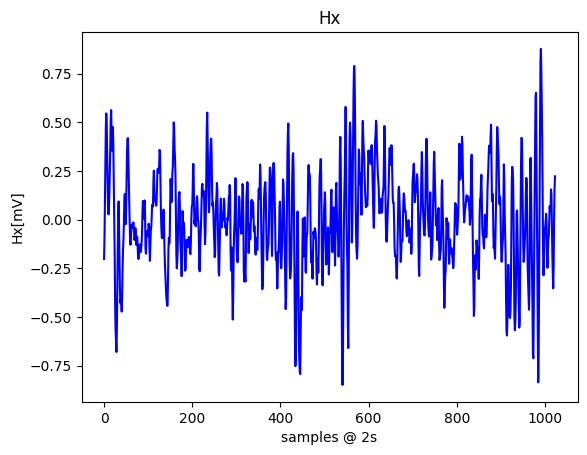

In [5]:
# plot the raw data
t = range(wl) # x axis
plt.title( channel['channel_type'])       # title
plt.xlabel("samples @ " + jh.sample_rate_to_string(channel['sample_rate']))
plt.ylabel(channel['channel_type'] + "[mV]")
plt.plot(t, hx, c='b', label='data')
plt.draw()


In [6]:
# define a function to run
# just simple smoothing function
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)
N = 40    # take for smoothing - looses 20 at begin and 19 ATE = 40 - 1
hx_smoothed = running_mean(hx, N)

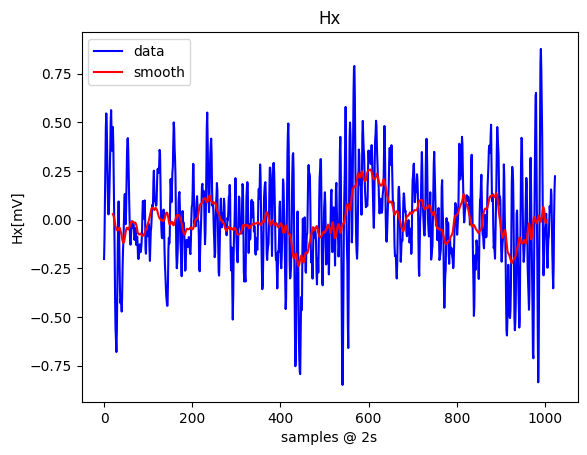

In [7]:
# and plot together
plt.close('all')
plt.title( channel['channel_type'])       # title
plt.xlabel("samples @ " + jh.sample_rate_to_string(channel['sample_rate']))
plt.ylabel(channel['channel_type'] + "[" + channel['units'] + "]")
plt.plot(t, hx, c='b', label='data')
plt.plot(t[20:1005], hx_smoothed, c='r', label='smooth')        # that axis is delayed by filter
plt.legend()
plt.show()

The calibration data is *always* included in the **JSON** file
When the header comes from an ADU system we stay with the *normalized by f* form;
this allows you to compare with the deleiverd txt files

$F_{on}(f) = \frac{ V_{output} }{H \enspace Hz} = 0.8 \frac{V}{nT} \cdot \frac{P_1}{1+P_1} \cdot \frac{1}{1+P_2} \cdot \frac{1}{1+P_4} \enspace / \enspace f$


In [ ]:
plt.title("calibration normalized by f")  # title
plt.xlabel("f [Hz]")
plt.ylabel("V/(nT*Hz)")
plt.loglog(channel['sensor_calibration']['f'],channel['sensor_calibration']['a'], label='chopper on', marker='.')
plt.show()

In [ ]:
window = np.hanning(1024)
hxspc = hx * window        
spec = rfft(hxspc, norm="backward")   # that is numpy default which includes some normalisation
wincal = np.sqrt(1.0 / (0.5 * 512.0))
spec *= wincal * 2.0                  # disagree with normalisation 
ampl_spec = abs(spec)
ampl_spec = ampl_spec[20:420]         # take not the complete data - gives better scale
ampl_freq = np.linspace(20, 420, 400, endpoint=True)
ampl_freq = ampl_freq * channel['sample_rate'] / wl

plt.title("apmlitude raw spectrum")      
plt.xlabel("f [Hz]")
plt.ylabel("mV/sqrt(Hz)")
plt.loglog(ampl_freq, ampl_spec)
plt.show()

In [ ]:
# make a rectangular fft and inverse fft for calibrated time series
spec = rfft(hx, norm="backward")
# apply theoretical calibration for this low frequencies
for i, x in enumerate(spec):
    f = (1.0 * i) / (1.0 * wl)      # make a double frequency
    spec[i] = jh.cal_mfs06e(i, f, spec[i], channel['sensor_calibration']['chopper'])

plt.close('all')
calts = irfft(spec)                 # now calibrated

plt.title( channel['channel_type'] + " " + channel['site'] + " [nT]")         #title
plt.xlabel("samples @ " + jh.sample_rate_to_string(channel['sample_rate']))
plt.ylabel(channel['channel_type'] + "[nT]")
plt.plot(t, calts, c='g')
plt.show()


